In [1]:
import json
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")


/root/miniconda/envs/openvla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Paths to your JSON datasets
hard_new_path = '/root/vla-clip/openvla/experiments/robot/libero/libero_rephrase_hard_new.json'
hard_path = '/root/vla-clip/openvla/experiments/robot/libero/libero_rephrase_hard.json'
out_set_path = '/root/vla-clip/openvla/experiments/robot/libero/libero_rephrase_out_set.json'

# Define the 5 tasks that have rollout data (from rollouts_ood_oracle/rephrase_25)
ROLLOUT_TASKS = [
    'pick up the black bowl next to the cookie box and place it on the plate',
    'pick up the black bowl next to the plate and place it on the plate', 
    'pick up the black bowl on the ramekin and place it on the plate',
    'pick up the black bowl on the stove and place it on the plate',
    'pick up the black bowl on the wooden cabinet and place it on the plate'
]

def normalize_task_name(task):
    """Normalize task names for matching between datasets."""
    import re
    return re.sub(r'\s+', ' ', task.strip().lower())

# Load all three datasets
print("Loading datasets...")
with open(hard_new_path, 'r') as f:
    hard_new_data = json.load(f)

with open(hard_path, 'r') as f:
    hard_data = json.load(f)

with open(out_set_path, 'r') as f:
    out_set_data = json.load(f)

# Extract ALL instructions first
all_originals = []
all_hard_new_rephrases = []
all_hard_rephrases = []
all_out_set_rephrases = []
all_four_way_pairs = []  # (original, [hard_new_rephrases], [hard_rephrases], [out_set_rephrases])

for group_name in hard_new_data.keys():
    print(f"Processing group: {group_name}")
    
    # Process all three datasets
    hard_new_group = hard_new_data[group_name]
    hard_group = hard_data[group_name]
    out_set_group = out_set_data[group_name]
    
    for idx in hard_new_group.keys():
        if idx in hard_group and idx in out_set_group:  # Make sure all three datasets have this instruction
            orig = hard_new_group[idx]['original']
            hard_new_reps = hard_new_group[idx]['rephrases']
            hard_reps = hard_group[idx]['rephrases']
            out_set_reps = out_set_group[idx]['rephrases']
            
            all_originals.append(orig)
            all_hard_new_rephrases.extend(hard_new_reps)
            all_hard_rephrases.extend(hard_reps)
            all_out_set_rephrases.extend(out_set_reps)
            all_four_way_pairs.append((orig, hard_new_reps, hard_reps, out_set_reps))

print(f'Found {len(all_originals)} total originals in datasets')

# Filter to only the 5 tasks that have rollout data
print(f"\n🎯 Filtering to only the {len(ROLLOUT_TASKS)} tasks with rollout data...")

# Normalize rollout task names for matching
normalized_rollout_tasks = [normalize_task_name(task) for task in ROLLOUT_TASKS]

# Filter to matching tasks only
originals = []
hard_new_rephrases = []
hard_rephrases = []
out_set_rephrases = []
four_way_pairs = []

for i, orig in enumerate(all_originals):
    normalized_orig = normalize_task_name(orig)
    
    if normalized_orig in normalized_rollout_tasks:
        orig_pair = all_four_way_pairs[i]
        originals.append(orig)
        hard_new_rephrases.extend(orig_pair[1])  # hard_new_reps
        hard_rephrases.extend(orig_pair[2])      # hard_reps
        out_set_rephrases.extend(orig_pair[3])   # out_set_reps
        four_way_pairs.append(orig_pair)

print(f'✅ Filtered to {len(originals)} originals with rollout data')
print(f'✅ Total hard_new rephrases: {len(hard_new_rephrases)}')
print(f'✅ Total hard rephrases: {len(hard_rephrases)}')
print(f'✅ Total out_set rephrases: {len(out_set_rephrases)}')
print(f'✅ Total four-way pairs: {len(four_way_pairs)}')
print(f'✅ Average hard_new rephrases per original: {len(hard_new_rephrases)/len(originals):.1f}')
print(f'✅ Average hard rephrases per original: {len(hard_rephrases)/len(originals):.1f}')
print(f'✅ Average out_set rephrases per original: {len(out_set_rephrases)/len(originals):.1f}')

print(f"\n📋 Filtered tasks:")
for i, orig in enumerate(originals):
    print(f"   {i+1}. {orig}")


Loading datasets...
Processing group: libero_spatial
Found 10 total originals in datasets

🎯 Filtering to only the 5 tasks with rollout data...
✅ Filtered to 5 originals with rollout data
✅ Total hard_new rephrases: 125
✅ Total hard rephrases: 125
✅ Total out_set rephrases: 125
✅ Total four-way pairs: 5
✅ Average hard_new rephrases per original: 25.0
✅ Average hard rephrases per original: 25.0
✅ Average out_set rephrases per original: 25.0

📋 Filtered tasks:
   1. pick up the black bowl on the ramekin and place it on the plate
   2. pick up the black bowl next to the cookie box and place it on the plate
   3. pick up the black bowl on the stove and place it on the plate
   4. pick up the black bowl next to the plate and place it on the plate
   5. pick up the black bowl on the wooden cabinet and place it on the plate


In [3]:
# ===== CONFIGURATION =====
# Set this to True to use OpenVLA text embeddings, False to use BERT
USE_OPENVLA_EMBEDDINGS = True  # Change this to False to use BERT instead

# Initialize device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load embedding models based on configuration
if USE_OPENVLA_EMBEDDINGS:
    from transformers import AutoModelForVision2Seq, AutoProcessor
    
    # Load OpenVLA model for text embeddings
    print("Loading OpenVLA model for text embeddings...")
    openvla_path = "openvla/openvla-7b-finetuned-libero-spatial"  # You can change this to your specific model path
    processor = AutoProcessor.from_pretrained(openvla_path, trust_remote_code=True)
    vla_model = AutoModelForVision2Seq.from_pretrained(
        openvla_path,
                torch_dtype=torch.bfloat16,
                low_cpu_mem_usage=True,
                trust_remote_code=True,
            )
            
    # Try to move to GPU first, fall back to CPU if CUDA memory issues
    vla_model = vla_model.to(device)
        
    vla_model.eval()
    
    def get_openvla_text_embedding(text, max_length=77):
        """Get OpenVLA text embedding using the model's text encoder"""
        with torch.no_grad():
            # Use the processor's tokenizer to process text
            text_inputs = processor.tokenizer(
                text, 
                return_tensors='pt', 
                truncation=True, 
                max_length=max_length, 
                padding='max_length'
            )
            # Use the same device as the model
            model_device = next(vla_model.parameters()).device
            input_ids = text_inputs['input_ids'].to(model_device)
            
            # Get text embeddings from the language model (HuggingFace structure)
            text_embeddings = vla_model.get_input_embeddings()(input_ids)
            
            # Use mean pooling across sequence length (or you can use first token like BERT)
            # Mean pooling to get a single embedding vector
            embeddings = text_embeddings.mean(dim=1).squeeze(0)
            embeddings = embeddings.float().cpu().numpy()
            
            return embeddings
                        
    print("OpenVLA model loaded successfully!")
    # Test the embedding function
    test_embedding = get_openvla_text_embedding('test')
    print(f"OpenVLA text embedding dim: {test_embedding.shape}")
    get_text_embedding = get_openvla_text_embedding
    embedding_model_name = "OpenVLA"

# Load BERT (either as primary or fallback)
if not USE_OPENVLA_EMBEDDINGS:
    from transformers import BertTokenizer, BertModel
    print("Loading BERT model...")
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model = bert_model.to(device)
    bert_model.eval()
    
    def get_bert_embedding(text, max_length=77):
        """Get BERT [CLS] token embedding for a text"""
        with torch.no_grad():
            inputs = bert_tokenizer(
                text, 
                return_tensors='pt', 
                truncation=True, 
                max_length=max_length, 
                padding='max_length'
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = bert_model(**inputs)
            # Use [CLS] token embedding (first token)
            return outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()
    
    print("BERT model loaded successfully!")
    print(f"BERT embedding dim: {get_bert_embedding('test').shape}")
    get_text_embedding = get_bert_embedding
    embedding_model_name = "BERT"

print(f"✅ Using {embedding_model_name} embeddings for analysis")
print(f"💡 To switch embedding models, change USE_OPENVLA_EMBEDDINGS at the top of this cell")


Using device: cuda


2025-07-12 01:49:46.655837: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-12 01:49:46.655886: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-12 01:49:46.656839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-12 01:49:46.662206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-12 01:49:47.432547: W tensorflow/compiler/tf2

Loading OpenVLA model for text embeddings...


Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s]


OpenVLA model loaded successfully!
OpenVLA text embedding dim: (4096,)
✅ Using OpenVLA embeddings for analysis
💡 To switch embedding models, change USE_OPENVLA_EMBEDDINGS at the top of this cell


In [4]:
# Compute embeddings for all texts
all_texts = originals + hard_new_rephrases + hard_rephrases + out_set_rephrases
all_labels = (['original'] * len(originals) + 
              ['hard_new'] * len(hard_new_rephrases) + 
              ['hard'] * len(hard_rephrases) + 
              ['out_set'] * len(out_set_rephrases))

print(f"Computing {embedding_model_name} embeddings...")
embeddings = []
for text in tqdm(all_texts, desc=f'Embedding texts with {embedding_model_name}'):
    emb = get_text_embedding(text)
    embeddings.append(emb)

embeddings = np.stack(embeddings)
print(f"Computed {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")
print(f"Breakdown: {len(originals)} originals, {len(out_set_rephrases)} out-set, {len(hard_rephrases)} hard")


Computing OpenVLA embeddings...


Embedding texts with OpenVLA: 100%|██████████| 380/380 [00:01<00:00, 208.01it/s]

Computed 380 embeddings of dimension 4096
Breakdown: 5 originals, 125 out-set, 125 hard


Applying t-SNE...


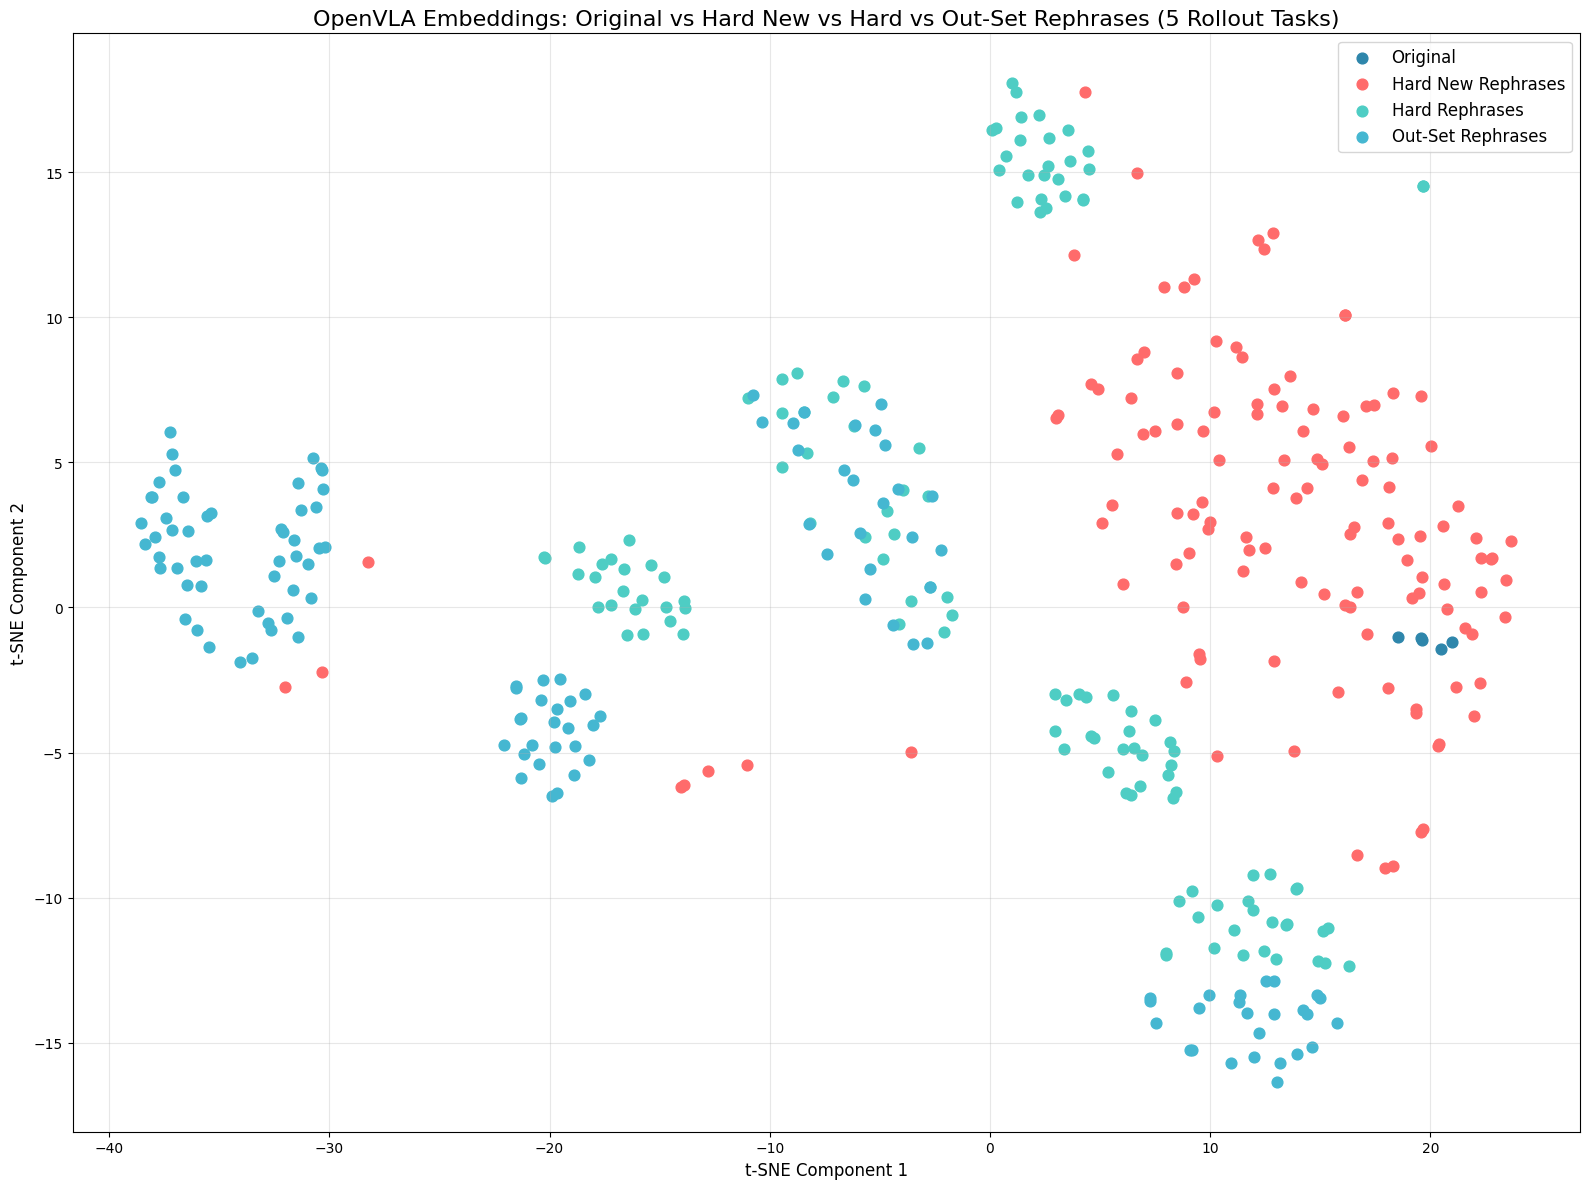

Plotted 5 originals, 125 hard_new rephrases, 125 hard rephrases, 125 out-set rephrases


In [5]:
# Apply t-SNE to all embeddings
print("Applying t-SNE...")
perplexity = min(30, len(embeddings) // 3)  # Adjust perplexity based on data size
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=1000)
emb_2d = tsne.fit_transform(embeddings)

# Create the four-way plot
plt.figure(figsize=(16, 12))
colors = ['#2E86AB', '#FF6B6B', '#4ECDC4', '#45B7D1']  # Blue for original, Red for hard_new, Teal for hard, Light Blue for out_set
labels = ['original', 'hard_new', 'hard', 'out_set']
label_names = ['Original', 'Hard New Rephrases', 'Hard Rephrases', 'Out-Set Rephrases']

for i, (label, name) in enumerate(zip(labels, label_names)):
    mask = np.array(all_labels) == label
    plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], 
                c=colors[i], label=name, 
                alpha=1, s=60)

plt.title(f'{embedding_model_name} Embeddings: Original vs Hard New vs Hard vs Out-Set Rephrases (5 Rollout Tasks)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Plotted {len(originals)} originals, {len(hard_new_rephrases)} hard_new rephrases, {len(hard_rephrases)} hard rephrases, {len(out_set_rephrases)} out-set rephrases")


Showing all 5 rollout task four-way pairs...


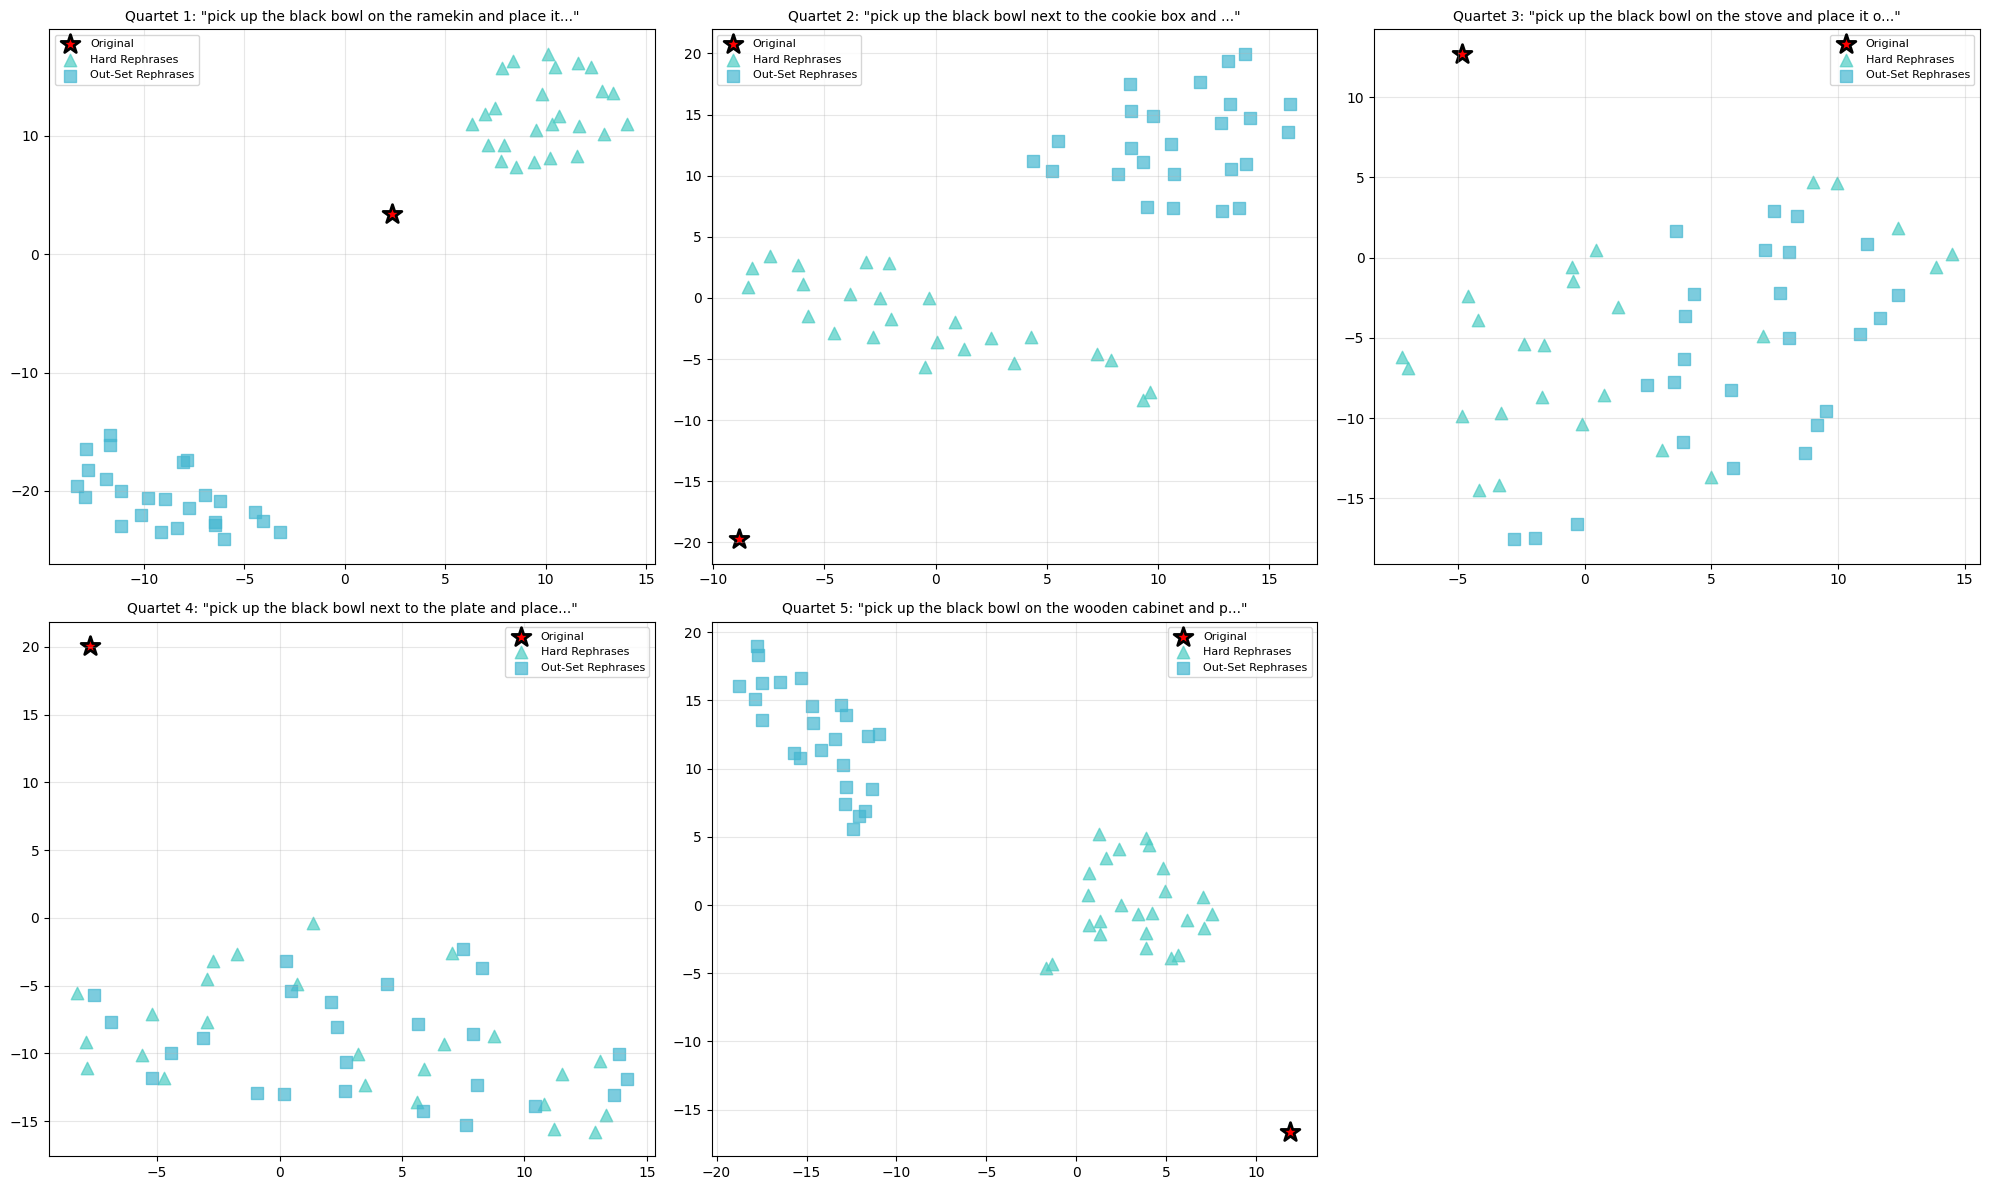

In [6]:
# Show all 5 rollout task four-way pairs
num_pairs_to_show = len(four_way_pairs)  # Should be 5
print(f"Showing all {num_pairs_to_show} rollout task four-way pairs...")

# Create layout for 5 plots (2x3 grid, last spot empty)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i in range(num_pairs_to_show):
    orig, hard_new_reps, hard_reps, out_set_reps = four_way_pairs[i]
    
    # Get embeddings for this four-way pair
    orig_emb = get_text_embedding(orig)
    hard_new_embs = np.stack([get_text_embedding(r) for r in hard_new_reps])
    hard_embs = np.stack([get_text_embedding(r) for r in hard_reps])
    out_set_embs = np.stack([get_text_embedding(r) for r in out_set_reps])
    
    # Combine for t-SNE
    pair_embeddings = np.vstack([orig_emb.reshape(1, -1), hard_new_embs, hard_embs, out_set_embs])
    
    # Apply t-SNE with adjusted perplexity
    n_samples = 1 + len(hard_new_reps) + len(hard_reps) + len(out_set_reps)
    perplexity = min(10, (n_samples - 1) // 3) if n_samples > 5 else 2
    
    try:
        tsne_pair = TSNE(n_components=2, random_state=42, perplexity=perplexity, max_iter=500)
        pair_2d = tsne_pair.fit_transform(pair_embeddings)
        
        # Plot
        ax = axes[i]
        # Original (red star)
        ax.scatter(pair_2d[0, 0], pair_2d[0, 1], c='red', s=200, marker='*', 
                  label='Original', edgecolors='black', linewidth=2)
        
        # Hard new rephrases (red circles)
        hard_new_start = 1
        hard_new_end = 1 + len(hard_new_reps)
        # ax.scatter(pair_2d[hard_new_start:hard_new_end, 0], pair_2d[hard_new_start:hard_new_end, 1], 
        #           c='#FF6B6B', s=80, alpha=0.7, marker='o', label='Hard New Rephrases')
        
        # Hard rephrases (teal triangles)
        hard_start = hard_new_end
        hard_end = hard_start + len(hard_reps)
        ax.scatter(pair_2d[hard_start:hard_end, 0], pair_2d[hard_start:hard_end, 1], 
                  c='#4ECDC4', s=80, alpha=0.7, marker='^', label='Hard Rephrases')
        
        # Out-set rephrases (light blue squares)
        out_set_start = hard_end
        ax.scatter(pair_2d[out_set_start:, 0], pair_2d[out_set_start:, 1], 
                  c='#45B7D1', s=80, alpha=0.7, marker='s', label='Out-Set Rephrases')
        
        ax.set_title(f'Quartet {i+1}: "{orig[:50]}..."', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
    except Exception as e:
        ax = axes[i]
        ax.text(0.5, 0.5, f'Error in t-SNE\nfor quartet {i+1}\n{str(e)[:30]}...', 
               ha='center', va='center', transform=ax.transAxes, fontsize=8)
        ax.set_title(f'Quartet {i+1}: Error', fontsize=10)

# Hide the last empty subplot if we have 5 tasks
if num_pairs_to_show == 5:
    axes[5].set_visible(False)

plt.tight_layout()
plt.show()


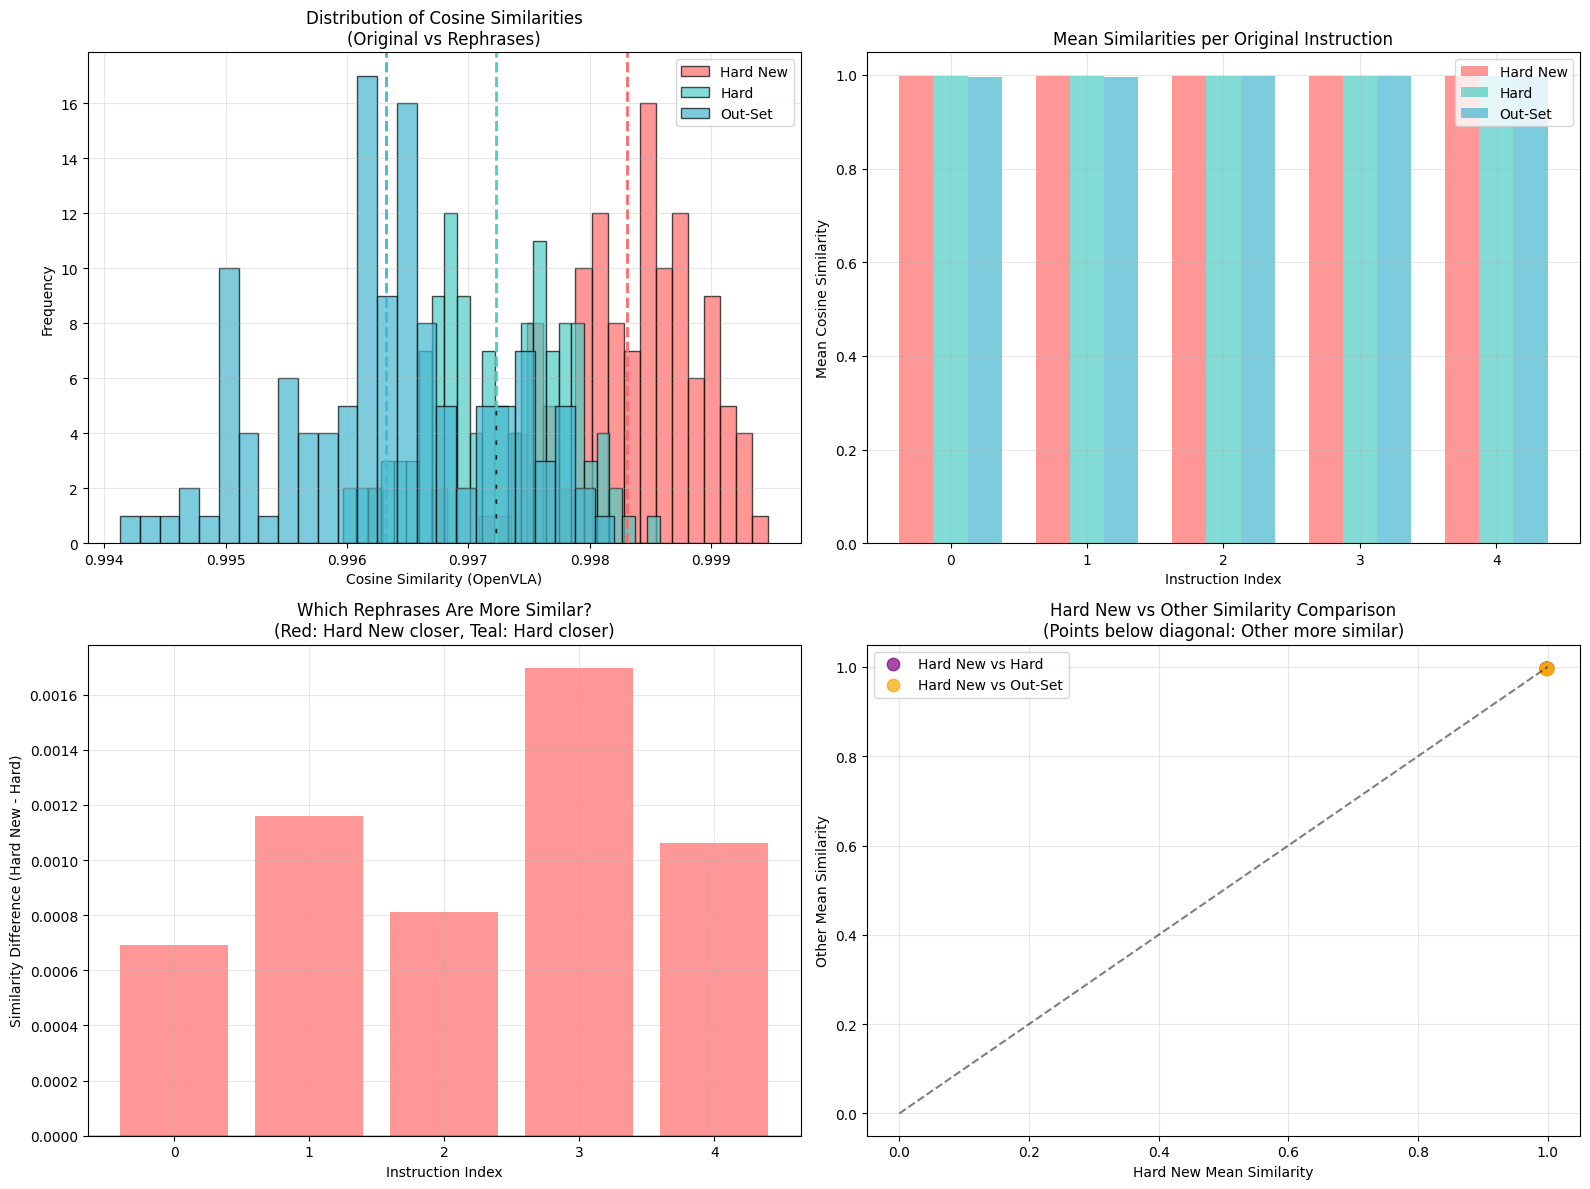

=== COMPREHENSIVE SIMILARITY ANALYSIS (OpenVLA EMBEDDINGS) ===

📊 HARD NEW REPHRASES:
   Mean similarity: 0.998
   Std similarity: 0.001
   Min similarity: 0.996
   Max similarity: 0.999

📊 HARD REPHRASES:
   Mean similarity: 0.997
   Std similarity: 0.001
   Min similarity: 0.996
   Max similarity: 0.999

📊 OUT-SET REPHRASES:
   Mean similarity: 0.996
   Std similarity: 0.001
   Min similarity: 0.994
   Max similarity: 0.998

🔍 COMPARISON:
   Hard New vs Hard: 0.001 (Hard New closer)
   Hard New vs Out-Set: 0.002 (Hard New closer)
   Hard vs Out-Set: 0.001 (Hard closer)
   Instructions where Hard New > Hard: 5/5
   Instructions where Hard New > Out-Set: 5/5
   Instructions where Hard > Out-Set: 4/5

📈 VARIABILITY:
   Hard New consistency (lower std = more consistent): 0.001
   Hard consistency (lower std = more consistent): 0.000
   Out-Set consistency (lower std = more consistent): 0.000


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarities between originals and all three types of rephrases
hard_new_similarities = []
hard_similarities = []
out_set_similarities = []
four_way_analysis = []

for i, (orig, hard_new_reps, hard_reps, out_set_reps) in enumerate(four_way_pairs):
    orig_emb = get_text_embedding(orig)
    
    # Compute similarities for hard_new rephrases
    hard_new_sims = []
    for rep in hard_new_reps:
        rep_emb = get_text_embedding(rep)
        sim = cosine_similarity([orig_emb], [rep_emb])[0, 0]
        hard_new_similarities.append(sim)
        hard_new_sims.append(sim)
    
    # Compute similarities for hard rephrases
    hard_sims = []
    for rep in hard_reps:
        rep_emb = get_text_embedding(rep)
        sim = cosine_similarity([orig_emb], [rep_emb])[0, 0]
        hard_similarities.append(sim)
        hard_sims.append(sim)
    
    # Compute similarities for out-set rephrases
    out_set_sims = []
    for rep in out_set_reps:
        rep_emb = get_text_embedding(rep)
        sim = cosine_similarity([orig_emb], [rep_emb])[0, 0]
        out_set_similarities.append(sim)
        out_set_sims.append(sim)
    
    four_way_analysis.append({
        'original': orig,
        'hard_new_similarities': hard_new_sims,
        'hard_similarities': hard_sims,
        'out_set_similarities': out_set_sims,
        'hard_new_mean': np.mean(hard_new_sims),
        'hard_mean': np.mean(hard_sims),
        'out_set_mean': np.mean(out_set_sims),
        'hard_new_std': np.std(hard_new_sims),
        'hard_std': np.std(hard_sims),
        'out_set_std': np.std(out_set_sims),
        'hard_new_vs_hard_diff': np.mean(hard_new_sims) - np.mean(hard_sims),
        'hard_new_vs_out_set_diff': np.mean(hard_new_sims) - np.mean(out_set_sims),
        'hard_vs_out_set_diff': np.mean(hard_sims) - np.mean(out_set_sims)
    })

# Create comprehensive similarity plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution comparison
ax1 = axes[0, 0]
ax1.hist(hard_new_similarities, bins=25, alpha=0.7, color='#FF6B6B', label='Hard New', edgecolor='black')
ax1.hist(hard_similarities, bins=25, alpha=0.7, color='#4ECDC4', label='Hard', edgecolor='black')
ax1.hist(out_set_similarities, bins=25, alpha=0.7, color='#45B7D1', label='Out-Set', edgecolor='black')
ax1.axvline(np.mean(hard_new_similarities), color='#FF6B6B', linestyle='--', linewidth=2)
ax1.axvline(np.mean(hard_similarities), color='#4ECDC4', linestyle='--', linewidth=2)
ax1.axvline(np.mean(out_set_similarities), color='#45B7D1', linestyle='--', linewidth=2)
ax1.set_xlabel(f'Cosine Similarity ({embedding_model_name})')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Cosine Similarities\n(Original vs Rephrases)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Mean similarities per instruction
ax2 = axes[0, 1]
hard_new_means = [item['hard_new_mean'] for item in four_way_analysis]
hard_means = [item['hard_mean'] for item in four_way_analysis]
out_set_means = [item['out_set_mean'] for item in four_way_analysis]
x_pos = np.arange(len(hard_new_means))
width = 0.25

ax2.bar(x_pos - width, hard_new_means, width, label='Hard New', color='#FF6B6B', alpha=0.7)
ax2.bar(x_pos, hard_means, width, label='Hard', color='#4ECDC4', alpha=0.7)
ax2.bar(x_pos + width, out_set_means, width, label='Out-Set', color='#45B7D1', alpha=0.7)
ax2.set_xlabel('Instruction Index')
ax2.set_ylabel('Mean Cosine Similarity')
ax2.set_title('Mean Similarities per Original Instruction')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Difference analysis (Hard New vs Hard)
ax3 = axes[1, 0]
differences = [item['hard_new_vs_hard_diff'] for item in four_way_analysis]
colors = ['#FF6B6B' if d > 0 else '#4ECDC4' for d in differences]
bars = ax3.bar(range(len(differences)), differences, color=colors, alpha=0.7)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Instruction Index')
ax3.set_ylabel('Similarity Difference (Hard New - Hard)')
ax3.set_title('Which Rephrases Are More Similar?\n(Red: Hard New closer, Teal: Hard closer)')
ax3.grid(True, alpha=0.3)

# 4. Scatter plot comparison
ax4 = axes[1, 1]
ax4.scatter(hard_new_means, hard_means, alpha=0.7, s=80, color='purple', label='Hard New vs Hard')
ax4.scatter(hard_new_means, out_set_means, alpha=0.7, s=80, color='orange', label='Hard New vs Out-Set')
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # Diagonal line
ax4.set_xlabel('Hard New Mean Similarity')
ax4.set_ylabel('Other Mean Similarity')
ax4.set_title('Hard New vs Other Similarity Comparison\n(Points below diagonal: Other more similar)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print(f"=== COMPREHENSIVE SIMILARITY ANALYSIS ({embedding_model_name} EMBEDDINGS) ===")
print(f"\n📊 HARD NEW REPHRASES:")
print(f"   Mean similarity: {np.mean(hard_new_similarities):.3f}")
print(f"   Std similarity: {np.std(hard_new_similarities):.3f}")
print(f"   Min similarity: {np.min(hard_new_similarities):.3f}")
print(f"   Max similarity: {np.max(hard_new_similarities):.3f}")

print(f"\n📊 HARD REPHRASES:")
print(f"   Mean similarity: {np.mean(hard_similarities):.3f}")
print(f"   Std similarity: {np.std(hard_similarities):.3f}")
print(f"   Min similarity: {np.min(hard_similarities):.3f}")
print(f"   Max similarity: {np.max(hard_similarities):.3f}")

print(f"\n📊 OUT-SET REPHRASES:")
print(f"   Mean similarity: {np.mean(out_set_similarities):.3f}")
print(f"   Std similarity: {np.std(out_set_similarities):.3f}")
print(f"   Min similarity: {np.min(out_set_similarities):.3f}")
print(f"   Max similarity: {np.max(out_set_similarities):.3f}")

print(f"\n🔍 COMPARISON:")
hard_new_vs_hard_diff = np.mean(hard_new_similarities) - np.mean(hard_similarities)
hard_new_vs_out_set_diff = np.mean(hard_new_similarities) - np.mean(out_set_similarities)
hard_vs_out_set_diff = np.mean(hard_similarities) - np.mean(out_set_similarities)

print(f"   Hard New vs Hard: {hard_new_vs_hard_diff:.3f} ({'Hard New' if hard_new_vs_hard_diff > 0 else 'Hard'} closer)")
print(f"   Hard New vs Out-Set: {hard_new_vs_out_set_diff:.3f} ({'Hard New' if hard_new_vs_out_set_diff > 0 else 'Out-Set'} closer)")
print(f"   Hard vs Out-Set: {hard_vs_out_set_diff:.3f} ({'Hard' if hard_vs_out_set_diff > 0 else 'Out-Set'} closer)")

# Count how many instructions favor each type
hard_new_vs_hard_wins = sum(1 for item in four_way_analysis if item['hard_new_vs_hard_diff'] > 0)
hard_new_vs_out_set_wins = sum(1 for item in four_way_analysis if item['hard_new_vs_out_set_diff'] > 0)
hard_vs_out_set_wins = sum(1 for item in four_way_analysis if item['hard_vs_out_set_diff'] > 0)

print(f"   Instructions where Hard New > Hard: {hard_new_vs_hard_wins}/{len(four_way_analysis)}")
print(f"   Instructions where Hard New > Out-Set: {hard_new_vs_out_set_wins}/{len(four_way_analysis)}")
print(f"   Instructions where Hard > Out-Set: {hard_vs_out_set_wins}/{len(four_way_analysis)}")

print(f"\n📈 VARIABILITY:")
print(f"   Hard New consistency (lower std = more consistent): {np.mean([item['hard_new_std'] for item in four_way_analysis]):.3f}")
print(f"   Hard consistency (lower std = more consistent): {np.mean([item['hard_std'] for item in four_way_analysis]):.3f}")
print(f"   Out-Set consistency (lower std = more consistent): {np.mean([item['out_set_std'] for item in four_way_analysis]):.3f}")


In [8]:
# Simple analysis: Oracle Rollouts rephrase_25 Success Rate vs Average Embedding Distance
import os
import re
from collections import defaultdict

def parse_oracle_rephrase_25(rollouts_dir='/root/vla-clip/openvla/rollouts_ood_oracle/rephrase_25'):
    """Parse rephrase_25 directory to extract success rates per task."""
    print("Parsing oracle rephrase_25 rollouts...")
    task_results = defaultdict(list)
    
    # Parse each episode file
    for filename in os.listdir(rollouts_dir):
        if filename.endswith('.pkl'):
            # Extract info from filename: episode=X--success=True/False--score=X.X--task=TASK_NAME.pkl
            match = re.match(r'episode=(\d+)--success=(True|False)--score=([\d\.-]+)--task=(.+)\.pkl', filename)
            if match:
                episode, success, score, task = match.groups()
                task = task.replace('_', ' ')  # Convert underscores to spaces
                success_bool = success == 'True'
                task_results[task].append(success_bool)
    
    # Calculate success rates per task
    task_success_rates = {}
    for task, successes in task_results.items():
        success_rate = sum(successes) / len(successes) if successes else 0
        task_success_rates[task] = {
            'success_rate': success_rate,
            'total_episodes': len(successes),
            'successful_episodes': sum(successes)
        }
    
    return task_success_rates

# Parse the oracle rephrase_25 data
oracle_results = parse_oracle_rephrase_25()

print(f"Found {len(oracle_results)} unique tasks in oracle rephrase_25:")
for task, stats in oracle_results.items():
    print(f"   {task}: {stats['success_rate']:.1%} ({stats['successful_episodes']}/{stats['total_episodes']})")


Parsing oracle rephrase_25 rollouts...
Found 5 unique tasks in oracle rephrase_25:
   pick up the black bowl on the ramekin and place it on the plate: 75.0% (15/20)
   pick up the black bowl next to the cookie box and place it on the plate: 85.0% (17/20)
   pick up the black bowl on the stove and place it on the plate: 55.0% (11/20)
   pick up the black bowl next to the plate and place it on the plate: 80.0% (16/20)
   pick up the black bowl on the wooden cabinet and place it on the plate: 20.0% (4/20)


In [9]:
# Match oracle tasks with our embedding analysis and create the correlation plot
def normalize_task_name(task):
    """Normalize task names for matching between datasets."""
    return re.sub(r'\s+', ' ', task.strip().lower())

# Create mapping between embedding data and oracle success rates
print("\nMatching embedding data with oracle success rates...")

# Normalize our original instructions for matching
normalized_originals = {}
for i, orig in enumerate(originals):
    normalized = normalize_task_name(orig)
    normalized_originals[normalized] = i

# Extract data for tasks that match both datasets
matched_tasks = []
for task, stats in oracle_results.items():
    normalized_task = normalize_task_name(task)
    
    if normalized_task in normalized_originals:
        orig_idx = normalized_originals[normalized_task]
        task_analysis = three_way_analysis[orig_idx]
        
        # Calculate average and minimum embedding distances
        avg_distance = (task_analysis['out_set_mean'] + task_analysis['hard_mean']) / 2
        avg_distance_converted = 1 - avg_distance  # Convert similarity to distance
        
        # Minimum distance = best (highest similarity) of the two types
        min_distance = min(1 - task_analysis['out_set_mean'], 1 - task_analysis['hard_mean'])
        
        matched_tasks.append({
            'task': originals[orig_idx],
            'success_rate': stats['success_rate'],
            'total_episodes': stats['total_episodes'],
            'avg_embedding_distance': avg_distance_converted,
            'min_embedding_distance': min_distance,
            'out_set_distance': 1 - task_analysis['out_set_mean'],
            'hard_distance': 1 - task_analysis['hard_mean']
        })

print(f"✅ Successfully matched {len(matched_tasks)} tasks")

# Display matched data
print(f"\n📄 Matched tasks data:")
for task_data in matched_tasks:
    print(f"   {task_data['task'][:50]}...")
    print(f"      Success Rate: {task_data['success_rate']:.1%}")
    print(f"      Avg Embedding Distance: {task_data['avg_embedding_distance']:.3f}")
    print(f"      Min Embedding Distance: {task_data['min_embedding_distance']:.3f}")
    print(f"      Episodes: {task_data['total_episodes']}")
    print()



Matching embedding data with oracle success rates...


NameError: name 'three_way_analysis' is not defined

Creating Success Rate vs Embedding Distance plots (Average and Minimum)...


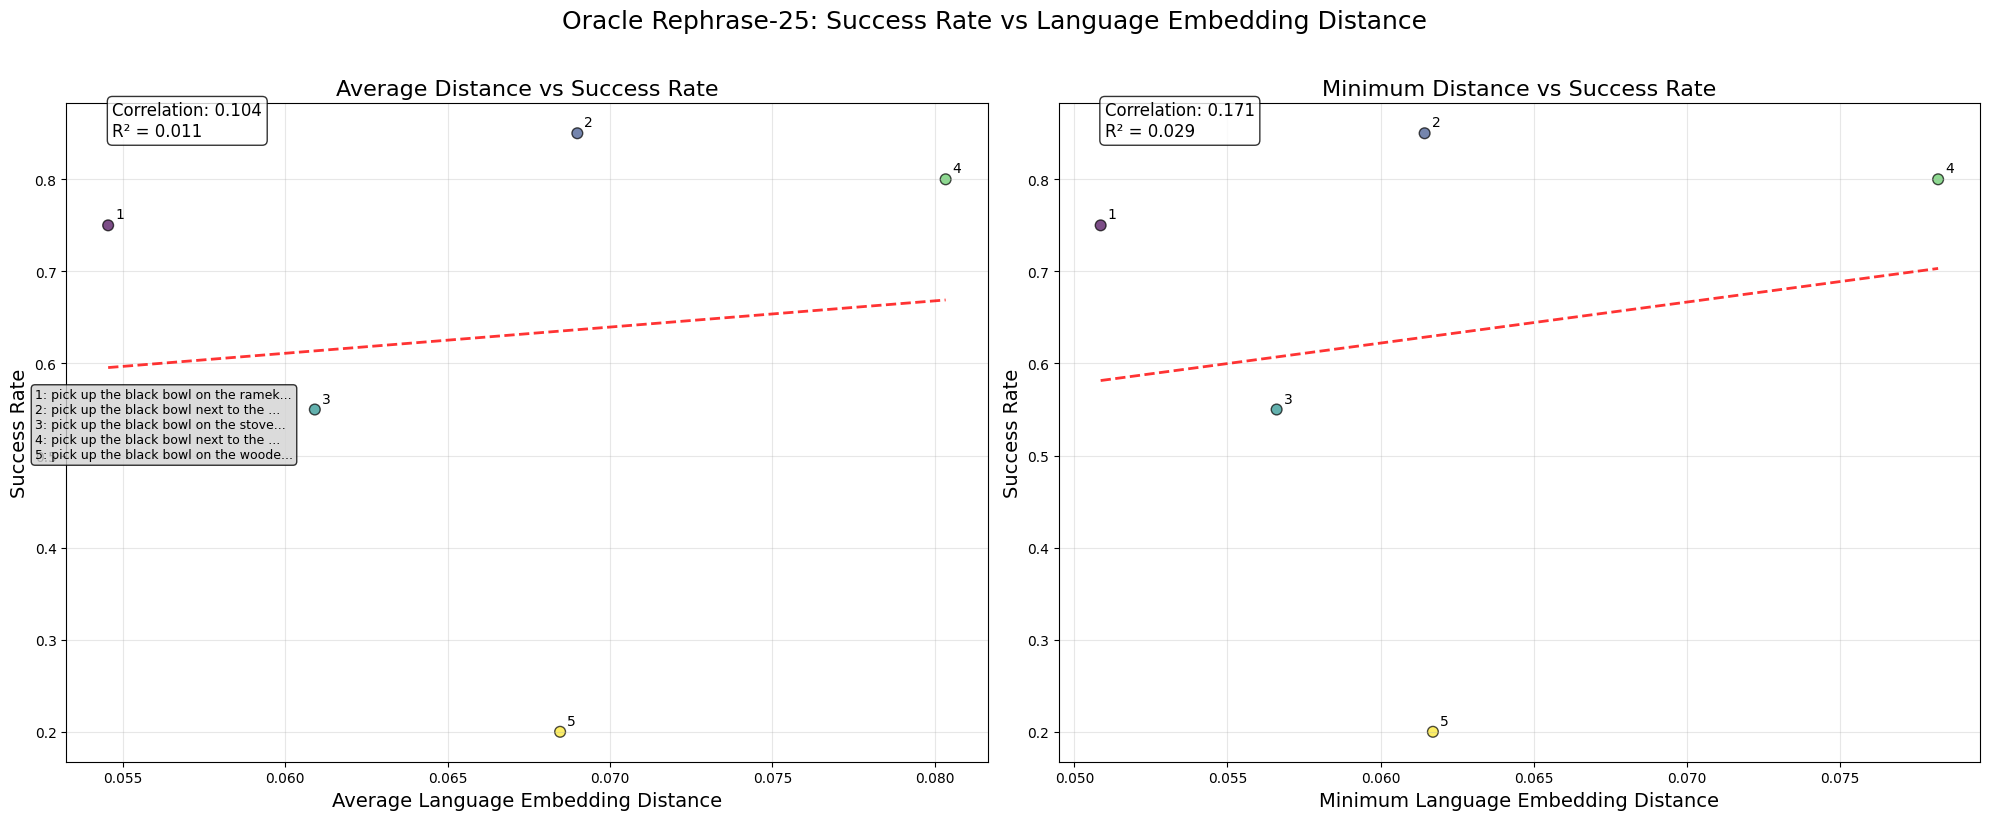


🔍 CORRELATION ANALYSIS:
   📊 Tasks analyzed: 5

📈 AVERAGE DISTANCE vs SUCCESS RATE:
   Correlation coefficient: 0.104
   R-squared: 0.011
   ✅ POSITIVE correlation: Higher avg distance → Higher success rate

📉 MINIMUM DISTANCE vs SUCCESS RATE:
   Correlation coefficient: 0.171
   R-squared: 0.029
   ✅ POSITIVE correlation: Higher min distance → Higher success rate

🎯 BETTER PREDICTOR: Minimum distance (|0.171| > |0.104|)
   📝 Interpretation: Best-case semantic similarity is more predictive than average

📋 DETAILED TASK SUMMARY:
   1. pick up the black bowl on the ramekin and place it on the plate
      Success: 75.0%
      Avg Distance: 0.055
      Min Distance: 0.051
   2. pick up the black bowl next to the cookie box and place it on the plate
      Success: 85.0%
      Avg Distance: 0.069
      Min Distance: 0.061
   3. pick up the black bowl on the stove and place it on the plate
      Success: 55.0%
      Avg Distance: 0.061
      Min Distance: 0.057
   4. pick up the black bowl n

In [ ]:
# Create dual plots: Success Rate vs Average and Minimum Language Embedding Distance
print("Creating Success Rate vs Embedding Distance plots (Average and Minimum)...")

# Extract data for plotting
success_rates = [task['success_rate'] for task in matched_tasks]
avg_distances = [task['avg_embedding_distance'] for task in matched_tasks]
min_distances = [task['min_embedding_distance'] for task in matched_tasks]
task_names = [task['task'] for task in matched_tasks]
total_episodes = [task['total_episodes'] for task in matched_tasks]

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Average Distance vs Success Rate
scatter1 = ax1.scatter(avg_distances, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='viridis',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for average distance
if len(avg_distances) > 1:
    corr_avg = np.corrcoef(avg_distances, success_rates)[0, 1]
    z_avg = np.polyfit(avg_distances, success_rates, 1)
    p_avg = np.poly1d(z_avg)
    x_trend_avg = np.linspace(min(avg_distances), max(avg_distances), 100)
    ax1.plot(x_trend_avg, p_avg(x_trend_avg), "r--", alpha=0.8, linewidth=2)
    
    ax1.text(0.05, 0.95, f'Correlation: {corr_avg:.3f}\nR² = {corr_avg**2:.3f}', 
             transform=ax1.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax1.set_xlabel('Average Language Embedding Distance', fontsize=14)
ax1.set_ylabel('Success Rate', fontsize=14)
ax1.set_title('Average Distance vs Success Rate', fontsize=16)
ax1.grid(True, alpha=0.3)

# Add task labels for plot 1
for i, (x, y) in enumerate(zip(avg_distances, success_rates)):
    ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Plot 2: Minimum Distance vs Success Rate
scatter2 = ax2.scatter(min_distances, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='viridis',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for minimum distance
if len(min_distances) > 1:
    corr_min = np.corrcoef(min_distances, success_rates)[0, 1]
    z_min = np.polyfit(min_distances, success_rates, 1)
    p_min = np.poly1d(z_min)
    x_trend_min = np.linspace(min(min_distances), max(min_distances), 100)
    ax2.plot(x_trend_min, p_min(x_trend_min), "r--", alpha=0.8, linewidth=2)
    
    ax2.text(0.05, 0.95, f'Correlation: {corr_min:.3f}\nR² = {corr_min**2:.3f}', 
             transform=ax2.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax2.set_xlabel('Minimum Language Embedding Distance', fontsize=14)
ax2.set_ylabel('Success Rate', fontsize=14)
ax2.set_title('Minimum Distance vs Success Rate', fontsize=16)
ax2.grid(True, alpha=0.3)

# Add task labels for plot 2
for i, (x, y) in enumerate(zip(min_distances, success_rates)):
    ax2.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Add overall title
fig.suptitle('Oracle Rephrase-25: Success Rate vs Language Embedding Distance', fontsize=18, y=1.02)

# Add shared colorbar
# cbar = fig.colorbar(scatter1, ax=[ax1, ax2], location='bottom', pad=0.1)
# cbar.set_label('Task Index', fontsize=12)

# Add legend for task numbers
legend_text = "\n".join([f"{i+1}: {task[:35]}{'...' if len(task) > 35 else ''}" 
                        for i, task in enumerate(task_names)])
fig.text(0.02, 0.5, legend_text, fontsize=9, ha='left', va='center',
         bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# Print correlation statistics for both
print(f"\n🔍 CORRELATION ANALYSIS:")
print(f"   📊 Tasks analyzed: {len(matched_tasks)}")

print(f"\n📈 AVERAGE DISTANCE vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_avg:.3f}")
print(f"   R-squared: {corr_avg**2:.3f}")
if corr_avg > 0:
    print(f"   ✅ POSITIVE correlation: Higher avg distance → Higher success rate")
else:
    print(f"   ⚠️  NEGATIVE correlation: Higher avg distance → Lower success rate")

print(f"\n📉 MINIMUM DISTANCE vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_min:.3f}")
print(f"   R-squared: {corr_min**2:.3f}")
if corr_min > 0:
    print(f"   ✅ POSITIVE correlation: Higher min distance → Higher success rate")
else:
    print(f"   ⚠️  NEGATIVE correlation: Higher min distance → Lower success rate")

# Compare which is a better predictor
if abs(corr_min) > abs(corr_avg):
    print(f"\n🎯 BETTER PREDICTOR: Minimum distance (|{corr_min:.3f}| > |{corr_avg:.3f}|)")
    print(f"   📝 Interpretation: Best-case semantic similarity is more predictive than average")
else:
    print(f"\n🎯 BETTER PREDICTOR: Average distance (|{corr_avg:.3f}| > |{corr_min:.3f}|)")
    print(f"   📝 Interpretation: Overall semantic similarity is more predictive than best-case")

print(f"\n📋 DETAILED TASK SUMMARY:")
for i, task_data in enumerate(matched_tasks):
    print(f"   {i+1}. {task_data['task']}")
    print(f"      Success: {task_data['success_rate']:.1%}")
    print(f"      Avg Distance: {task_data['avg_embedding_distance']:.3f}")
    print(f"      Min Distance: {task_data['min_embedding_distance']:.3f}")

print(f"\n💡 INTERPRETATION:")
print(f"   • Point size represents number of episodes ({min(total_episodes)}-{max(total_episodes)})")
print(f"   • Lower embedding distance = More similar to original instruction")
print(f"   • Average distance = Mean of hard and out-set rephrase distances")
print(f"   • Minimum distance = Best (lowest) distance from either rephrase type")
print(f"   • This comparison shows whether best-case or average similarity matters more")


In [ ]:
# Calculate diversity metrics for each task's rephrases
print("Calculating rephrase diversity metrics...")

# Enhance matched_tasks with diversity metrics
for i, task_data in enumerate(matched_tasks):
    orig_idx = normalized_originals[normalize_task_name(task_data['task'])]
    task_analysis = three_way_analysis[orig_idx]
    
    # Get embedding distances for all rephrases of this task
    out_set_distances = [1 - sim for sim in task_analysis['out_set_similarities']]
    hard_distances = [1 - sim for sim in task_analysis['hard_similarities']]
    all_distances = out_set_distances + hard_distances
    
    # Calculate diversity metrics
    distance_std = np.std(all_distances)  # Standard deviation of distances
    distance_range = max(all_distances) - min(all_distances)  # Range of distances
    cross_type_diversity = abs(task_data['out_set_distance'] - task_data['hard_distance'])  # Distance between hard/out-set means
    
    # Add to task data
    task_data['distance_diversity'] = distance_std
    task_data['distance_range'] = distance_range
    task_data['cross_type_diversity'] = cross_type_diversity
    task_data['total_rephrases'] = len(all_distances)

print("✅ Diversity metrics calculated for all tasks")

# Display diversity data
print(f"\n📊 DIVERSITY METRICS SUMMARY:")
for i, task_data in enumerate(matched_tasks):
    print(f"   {i+1}. {task_data['task'][:50]}...")
    print(f"      Success Rate: {task_data['success_rate']:.1%}")
    print(f"      Distance Std Dev: {task_data['distance_diversity']:.4f}")
    print(f"      Distance Range: {task_data['distance_range']:.4f}")
    print(f"      Cross-type Diversity: {task_data['cross_type_diversity']:.4f}")
    print(f"      Total Rephrases: {task_data['total_rephrases']}")
    print()

# Extract diversity metrics for plotting
diversity_metrics = [task['distance_diversity'] for task in matched_tasks]
range_metrics = [task['distance_range'] for task in matched_tasks]
cross_type_metrics = [task['cross_type_diversity'] for task in matched_tasks]
success_rates = [task['success_rate'] for task in matched_tasks]
task_names = [task['task'] for task in matched_tasks]
total_episodes = [task['total_episodes'] for task in matched_tasks]


Calculating rephrase diversity metrics...
✅ Diversity metrics calculated for all tasks

📊 DIVERSITY METRICS SUMMARY:
   1. pick up the black bowl on the ramekin and place it...
      Success Rate: 75.0%
      Distance Std Dev: 0.0139
      Distance Range: 0.0648
      Cross-type Diversity: 0.0074
      Total Rephrases: 50

   2. pick up the black bowl next to the cookie box and ...
      Success Rate: 85.0%
      Distance Std Dev: 0.0260
      Distance Range: 0.1173
      Cross-type Diversity: 0.0151
      Total Rephrases: 50

   3. pick up the black bowl on the stove and place it o...
      Success Rate: 55.0%
      Distance Std Dev: 0.0162
      Distance Range: 0.0721
      Cross-type Diversity: 0.0086
      Total Rephrases: 50

   4. pick up the black bowl next to the plate and place...
      Success Rate: 80.0%
      Distance Std Dev: 0.0204
      Distance Range: 0.0939
      Cross-type Diversity: 0.0042
      Total Rephrases: 50

   5. pick up the black bowl on the wooden cabinet 

Creating Diversity vs Success Rate plots...


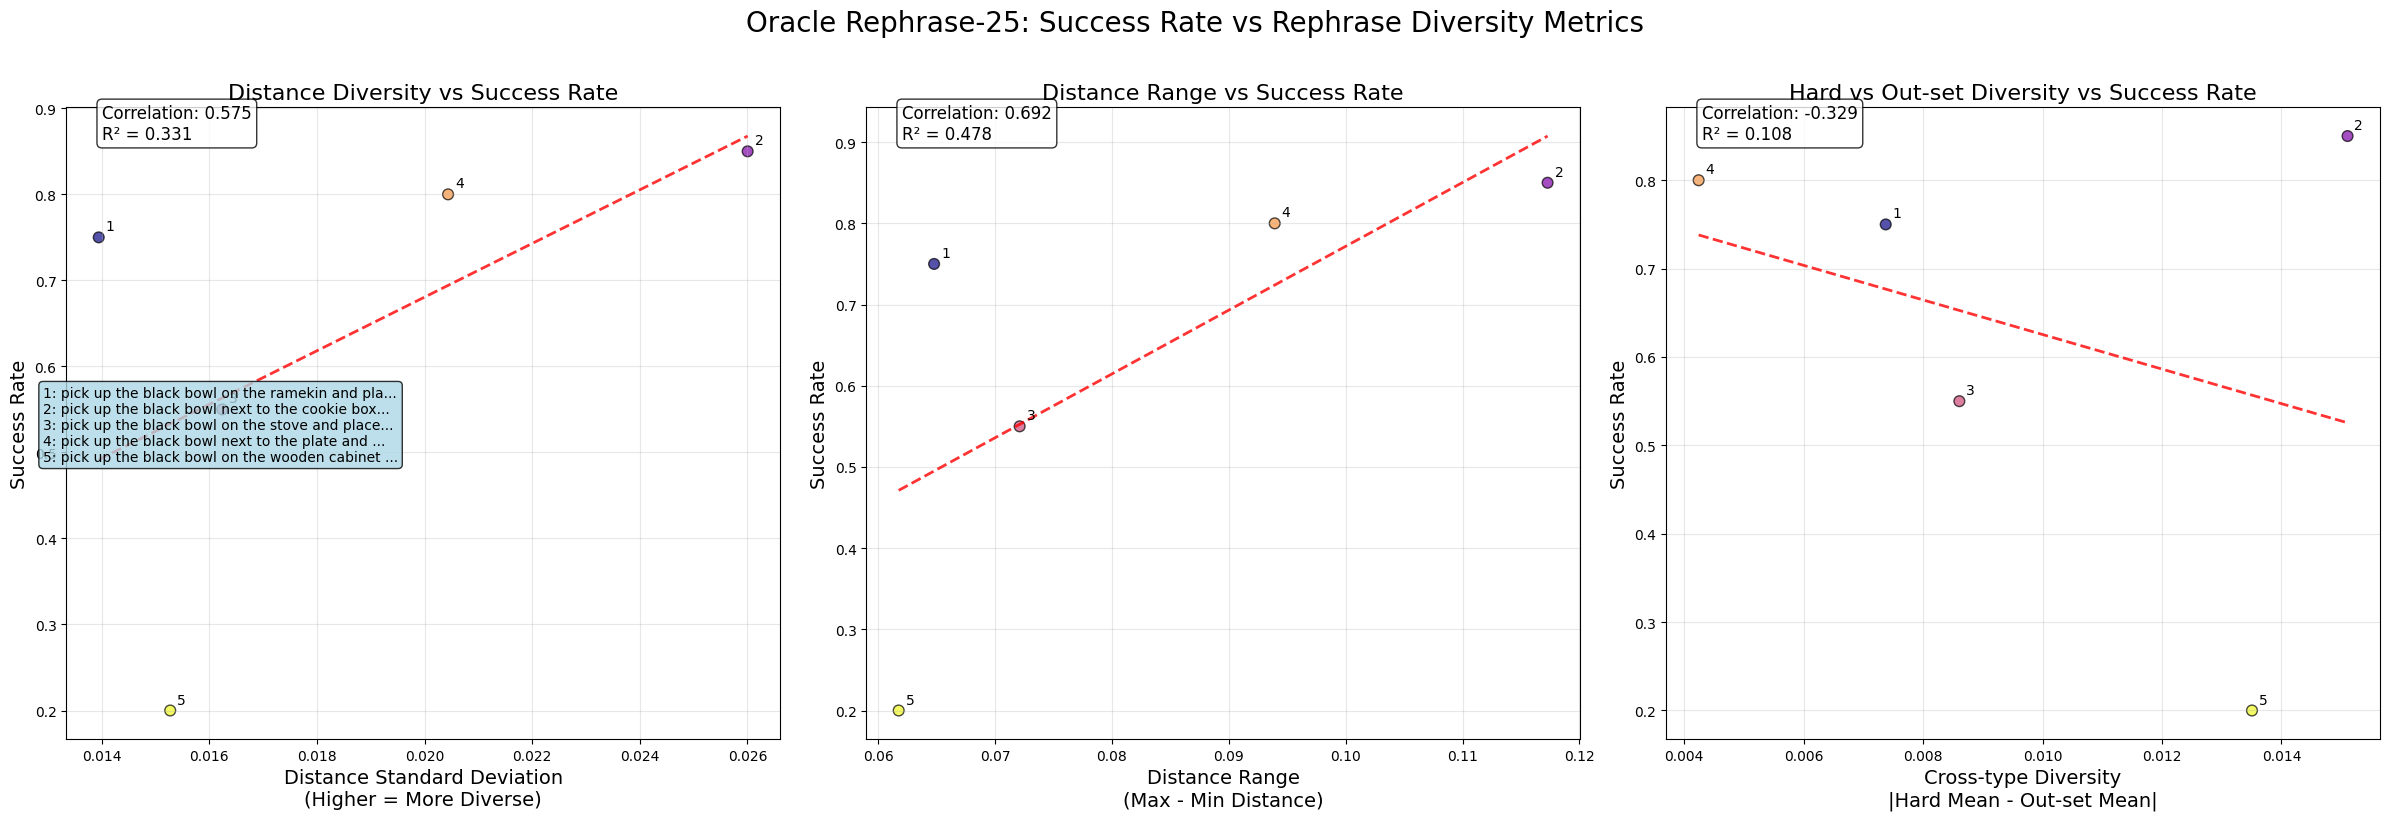


🎯 DIVERSITY vs SUCCESS RATE ANALYSIS:
   📊 Tasks analyzed: 5

📈 DISTANCE DIVERSITY (Standard Deviation) vs SUCCESS RATE:
   Correlation coefficient: 0.575
   R-squared: 0.331
   ✅ POSITIVE correlation: Higher diversity → Higher success rate
   📝 Interpretation: More diverse rephrases help robot performance

📉 DISTANCE RANGE vs SUCCESS RATE:
   Correlation coefficient: 0.692
   R-squared: 0.478
   ✅ POSITIVE correlation: Larger range → Higher success rate

🔄 CROSS-TYPE DIVERSITY vs SUCCESS RATE:
   Correlation coefficient: -0.329
   R-squared: 0.108
   ⚠️  NEGATIVE correlation: More difference between hard/out-set → Lower success

🏆 STRONGEST DIVERSITY PREDICTOR: Distance Range (|0.692|)

💡 PRACTICAL IMPLICATIONS:
   🎯 Training Strategy: Include diverse rephrases with varying semantic distances
   📝 Benefit: Semantic diversity appears to improve robustness

📋 DETAILED DIVERSITY BREAKDOWN:
   1. Success: 75.0%
      Diversity (std): 0.0139
      Range: 0.0648
      Cross-type: 0.0074
  

In [ ]:
# Create comprehensive diversity vs success rate plots
print("Creating Diversity vs Success Rate plots...")

# Create triple plots: three different diversity metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot 1: Distance Standard Deviation vs Success Rate
scatter1 = ax1.scatter(diversity_metrics, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='plasma',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for distance diversity
if len(diversity_metrics) > 1:
    corr_div = np.corrcoef(diversity_metrics, success_rates)[0, 1]
    z_div = np.polyfit(diversity_metrics, success_rates, 1)
    p_div = np.poly1d(z_div)
    x_trend_div = np.linspace(min(diversity_metrics), max(diversity_metrics), 100)
    ax1.plot(x_trend_div, p_div(x_trend_div), "r--", alpha=0.8, linewidth=2)
    
    ax1.text(0.05, 0.95, f'Correlation: {corr_div:.3f}\nR² = {corr_div**2:.3f}', 
             transform=ax1.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax1.set_xlabel('Distance Standard Deviation\n(Higher = More Diverse)', fontsize=14)
ax1.set_ylabel('Success Rate', fontsize=14)
ax1.set_title('Distance Diversity vs Success Rate', fontsize=16)
ax1.grid(True, alpha=0.3)

# Add task labels for plot 1
for i, (x, y) in enumerate(zip(diversity_metrics, success_rates)):
    ax1.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Plot 2: Distance Range vs Success Rate
scatter2 = ax2.scatter(range_metrics, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='plasma',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for distance range
if len(range_metrics) > 1:
    corr_range = np.corrcoef(range_metrics, success_rates)[0, 1]
    z_range = np.polyfit(range_metrics, success_rates, 1)
    p_range = np.poly1d(z_range)
    x_trend_range = np.linspace(min(range_metrics), max(range_metrics), 100)
    ax2.plot(x_trend_range, p_range(x_trend_range), "r--", alpha=0.8, linewidth=2)
    
    ax2.text(0.05, 0.95, f'Correlation: {corr_range:.3f}\nR² = {corr_range**2:.3f}', 
             transform=ax2.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax2.set_xlabel('Distance Range\n(Max - Min Distance)', fontsize=14)
ax2.set_ylabel('Success Rate', fontsize=14)
ax2.set_title('Distance Range vs Success Rate', fontsize=16)
ax2.grid(True, alpha=0.3)

# Add task labels for plot 2
for i, (x, y) in enumerate(zip(range_metrics, success_rates)):
    ax2.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Plot 3: Cross-type Diversity vs Success Rate
scatter3 = ax3.scatter(cross_type_metrics, success_rates, 
                      s=[ep * 3 for ep in total_episodes],
                      alpha=0.7, 
                      c=range(len(matched_tasks)), 
                      cmap='plasma',
                      edgecolors='black',
                      linewidth=1)

# Add trend line for cross-type diversity
if len(cross_type_metrics) > 1:
    corr_cross = np.corrcoef(cross_type_metrics, success_rates)[0, 1]
    z_cross = np.polyfit(cross_type_metrics, success_rates, 1)
    p_cross = np.poly1d(z_cross)
    x_trend_cross = np.linspace(min(cross_type_metrics), max(cross_type_metrics), 100)
    ax3.plot(x_trend_cross, p_cross(x_trend_cross), "r--", alpha=0.8, linewidth=2)
    
    ax3.text(0.05, 0.95, f'Correlation: {corr_cross:.3f}\nR² = {corr_cross**2:.3f}', 
             transform=ax3.transAxes, 
             bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
             fontsize=12)

ax3.set_xlabel('Cross-type Diversity\n|Hard Mean - Out-set Mean|', fontsize=14)
ax3.set_ylabel('Success Rate', fontsize=14)
ax3.set_title('Hard vs Out-set Diversity vs Success Rate', fontsize=16)
ax3.grid(True, alpha=0.3)

# Add task labels for plot 3
for i, (x, y) in enumerate(zip(cross_type_metrics, success_rates)):
    ax3.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontsize=10, ha='left')

# Add overall title
fig.suptitle('Oracle Rephrase-25: Success Rate vs Rephrase Diversity Metrics', fontsize=20, y=1.02)

# Add legend for task numbers at the bottom
legend_text = "\n".join([f"{i+1}: {task[:45]}{'...' if len(task) > 45 else ''}" 
                        for i, task in enumerate(task_names)])
fig.text(0.02, 0.5, legend_text, fontsize=10, ha='left', va='center',
         bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# Print comprehensive diversity analysis
print(f"\n🎯 DIVERSITY vs SUCCESS RATE ANALYSIS:")
print(f"   📊 Tasks analyzed: {len(matched_tasks)}")

print(f"\n📈 DISTANCE DIVERSITY (Standard Deviation) vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_div:.3f}")
print(f"   R-squared: {corr_div**2:.3f}")
if corr_div > 0:
    print(f"   ✅ POSITIVE correlation: Higher diversity → Higher success rate")
    print(f"   📝 Interpretation: More diverse rephrases help robot performance")
else:
    print(f"   ⚠️  NEGATIVE correlation: Higher diversity → Lower success rate")
    print(f"   📝 Interpretation: More consistent rephrases help robot performance")

print(f"\n📉 DISTANCE RANGE vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_range:.3f}")
print(f"   R-squared: {corr_range**2:.3f}")
if corr_range > 0:
    print(f"   ✅ POSITIVE correlation: Larger range → Higher success rate")
else:
    print(f"   ⚠️  NEGATIVE correlation: Larger range → Lower success rate")

print(f"\n🔄 CROSS-TYPE DIVERSITY vs SUCCESS RATE:")
print(f"   Correlation coefficient: {corr_cross:.3f}")
print(f"   R-squared: {corr_cross**2:.3f}")
if corr_cross > 0:
    print(f"   ✅ POSITIVE correlation: More difference between hard/out-set → Higher success")
else:
    print(f"   ⚠️  NEGATIVE correlation: More difference between hard/out-set → Lower success")

# Find the strongest diversity predictor
diversity_correlations = {
    'Distance Diversity': abs(corr_div),
    'Distance Range': abs(corr_range),
    'Cross-type Diversity': abs(corr_cross)
}
best_predictor = max(diversity_correlations.keys(), key=lambda k: diversity_correlations[k])
best_corr = diversity_correlations[best_predictor]

print(f"\n🏆 STRONGEST DIVERSITY PREDICTOR: {best_predictor} (|{best_corr:.3f}|)")

print(f"\n💡 PRACTICAL IMPLICATIONS:")
if corr_div < 0:
    print(f"   🎯 Training Strategy: Focus on consistent, semantically tight rephrases")
    print(f"   📝 Avoid: High variance in rephrase semantic distances")
else:
    print(f"   🎯 Training Strategy: Include diverse rephrases with varying semantic distances")
    print(f"   📝 Benefit: Semantic diversity appears to improve robustness")

print(f"\n📋 DETAILED DIVERSITY BREAKDOWN:")
for i, task_data in enumerate(matched_tasks):
    print(f"   {i+1}. Success: {task_data['success_rate']:.1%}")
    print(f"      Diversity (std): {task_data['distance_diversity']:.4f}")
    print(f"      Range: {task_data['distance_range']:.4f}") 
    print(f"      Cross-type: {task_data['cross_type_diversity']:.4f}")
    print(f"      Rephrases: {task_data['total_rephrases']}")
    print()
